In [35]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
plt.style.use('dark_background')
%matplotlib inline

In [36]:
np.set_printoptions(precision=2)

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [38]:
tf.__version__

'2.15.0'

---

Mount Google Drive if running in Colab

---

In [39]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/EvenSem2024MAHE'
    DATA_DIR = DIR + '/Data/'
    os.chdir(DIR)
else:
    DATA_DIR = 'Data/'

---

Load diabetes data

---

In [40]:
## Load diabetes data
file = 'diabetes_regression1.csv'
df= pd.read_csv(file, header = 0)

print('Diabetes dataset')
print('-----------')
print('Initial number of samples = %d'%(df.shape[0]))
print('Initial number of features = %d\n'%(df.shape[1]))
df.head(5)

Diabetes dataset
-----------
Initial number of samples = 442
Initial number of features = 11



,AGE,GENDER,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [41]:
## Create lists of ordinal, categorical, and continuous features
#categorical_features =  ['GENDER', 'BMILEVEL']
categorical_features =  ['GENDER']
continuous_features = df.drop(categorical_features, axis = 1).columns.tolist()
print(categorical_features)
print(continuous_features)

['GENDER']
['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'Y']


---

Assign 'category' datatype to categorical columns

---

In [42]:
## Assign 'category' datatype to ordinal and categorical columns
print(df.dtypes)
df[categorical_features] = df[categorical_features].astype('category')
print('----')
df.dtypes

AGE         int64
GENDER      int64
BMI       float64
BP        float64
S1          int64
S2        float64
S3        float64
S4        float64
S5        float64
S6          int64
Y           int64
dtype: object
----


AGE          int64
GENDER    category
BMI        float64
BP         float64
S1           int64
S2         float64
S3         float64
S4         float64
S5         float64
S6           int64
Y            int64
dtype: object

---

Remove the target variable column from the list of continuous features

---

In [43]:
## Remove the target variable column from the list of continuous features
continuous_features.remove('Y')

In [44]:
## Train and test split of the data
X = df.drop('Y', axis = 1)
y = df['Y']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

num_features = X_train.shape[0]
num_samples = X_train.shape[1]

print('Diabetes data set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))

Diabetes data set
---------------------
Number of training samples = 10
Number of features = 353


---

Build pipeline for categorical and continuous features

---

In [45]:
## Build pipeline for categorical and continuous features

# Pipeline object for categorical (features
categorical_transformer = Pipeline(steps = [('onehotenc', OneHotEncoder(handle_unknown = 'ignore'))])

# Pipeline object for continuous features
continuous_transformer = Pipeline(steps = [('scaler', RobustScaler())])

# Create a preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('continuous', continuous_transformer, continuous_features),
                                                 ('categorical', categorical_transformer, categorical_features)
                                                ],
                                 remainder = 'passthrough'
                                 )

---

Fit and transform train data using preprocessor followed by transforming test data

---

In [46]:
## Fit and transform train data using preprocessor
X_train_transformed = preprocessor.fit_transform(X_train).T
# Update number of features
num_features = X_train_transformed.shape[0]
# Transform training data using preprocessor
X_test_transformed = preprocessor.transform(X_test).T
# Convert Y_train and Y_test to numpy arrays
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

---

A generic layer class with forward and backward methods

----

In [47]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

---

Mean squared error (MSE) loss and its gradient

---

In [48]:
## Define the loss function and its gradient
def mse(Y, Yhat):
  return(np.mean(0.5*(Y - Yhat)**2))
  #TensorFlow in-built function for mean squared error loss
  #mse = tf.keras.losses.MeanSquaredError()
  #mse(Y, Yhat).numpy()

def mse_gradient(Y, Yhat):
  return(Yhat - Y)

---

Generic activation layer class

---

In [49]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(output_gradient[:-1, :] * self.activation_gradient(self.input))

---

Specific activation layer classes

---

In [50]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1 - a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            a = np.tanh(z)
            return 1 - a**2

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

---

Dense layer class

---

In [51]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength):
        self.weights = 0.01*np.random.randn(output_size, input_size+1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
        # Calculate regularization loss
        self.reg_loss = self.reg_strength * np.sum(self.weights[:, :-1] * self.weights[:, :-1])

    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        #weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        #for b in range(output_gradient.shape[1]):
        #  weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        #weights_gradient = (1/output_gradient.shape[1])*weights_gradient

        ## Following is the efficient way of calculating the weights gradient w.r.t. data
        weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        # Add the regularization gradient here
        weights_gradient += 2 * self.reg_strength * np.hstack([self.weights[:, :-1], np.zeros((self.weights.shape[0], 1))])


        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights = self.weights + learning_rate * (-weights_gradient)

        return(input_gradient)

---

Function to generate sample indices for batch processing according to batch size

---

In [52]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

---

Train the 3-layer neural network (8/8/1 structure) using batch training with batch size = 16

---

In [ ]:
## Train the 2-hidden layer neural network (8 nodes, 8 nodes followed by 1 node)
## using batch training with batch size = 100
learning_rate = 1e-04 # learning rate
batch_size = 32 # batch size
nepochs = 10000 # number of epochs
reg_strength = 1.0 # regularization strength
# Create empty array to store training losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64)
# Create empty array to store test losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64)


# Neural network architecture

dlayer1 = Dense(num_features, 16, reg_strength) # define dense layer 1
alayer1 = Tanh() # ReLU activation layer 1
dlayer2 = Dense(16, 1, reg_strength) # define dense layer 2


# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.

epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  for b in range(len(batch_indices)):
    # Forward propagation for training data
    dlayer1.forward(X_train_transformed[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    # Calculate training data loss
    loss += mse(Y_train[batch_indices[b]], dlayer2.output)
    # Add the regularization losses
    loss += dlayer1.reg_loss + dlayer2.reg_loss

    # Backward prop starts here
    grad = mse_gradient(Y_train[batch_indices[b]], dlayer2.output)
    grad = dlayer2.backward(grad, learning_rate)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)
  # Calculate the average training loss for the current epoch
  loss_train_epoch[epoch] = loss/len(batch_indices)

  # Forward propagation for test data
  dlayer1.forward(X_test_transformed)
  alayer1.forward(dlayer1.output)
  dlayer2.forward(alayer1.output)

  # Calculate test data loss plus regularization loss
  loss_test_epoch[epoch] =  mse(Y_test, dlayer2.output) + dlayer1.reg_loss + dlayer2.reg_loss

  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  epoch = epoch + 1

---

Plot training loss vs. epoch

---

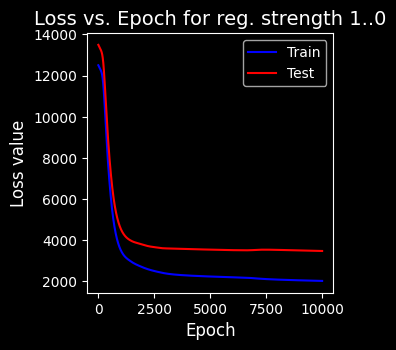

In [54]:
# Plot train and test loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot(loss_train_epoch, 'b', label = 'Train')
ax.plot(loss_test_epoch, 'r', label = 'Test')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.legend()
ax.set_title('Loss vs. Epoch for reg. strength 1..0', fontsize = 14);

---

Test performance on test data

---

In [55]:
dlayer1.forward(X_test_transformed)
alayer1.forward(dlayer1.output)
dlayer2.forward(alayer1.output)
ypred = dlayer2.output.flatten()
ytrue = Y_test

---

Define neural network architecture for regression

---

In [56]:
# Define neural network architecture for regression
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train_transformed.T.shape[1], ), kernel_regularizer = keras.regularizers.l2(l = 1.0)),
    layers.Dense(1)
])

In [57]:
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train_transformed.T.shape[1], ), kernel_regularizer = keras.regularizers.l2(l = 1.0)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

---

Compile the neural network

---

In [58]:
# Compile the neural network model
opt = tf.keras.optimizers.Adam(learning_rate = 1e-04)
model.compile(optimizer = opt, loss = 'mean_squared_error')

---

Train the model

---

In [ ]:
# Train the model
history = model.fit(X_train_transformed.T, Y_train, epochs = 10000, batch_size = 32, validation_data=(X_test_transformed.T, Y_test))

---

Plot train and test loss as a function of epoch

---

Text(0.5, 1.0, 'Loss vs. Epoch for reg. strength 1.0')

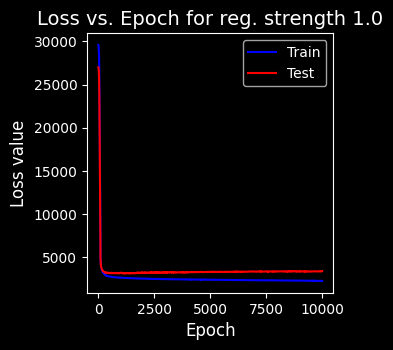

In [60]:
# Plot train and test loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot( history.history['loss'], 'b', label = 'Train')
ax.plot( history.history['val_loss'], 'r', label = 'Test')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.legend()
ax.set_title('Loss vs. Epoch for reg. strength 1.0', fontsize = 14)


---

Compare the true and predicted values

---

In [ ]:
## Compare the true and predicted values
ypred_TF = model.predict(X_test_transformed.T)
np.column_stack((Y_test, ypred, ypred_TF))

In [76]:
# sir madsid
b = 8 # batch size
nl = 10 # number of nodes in layer l
probability_dropout = 0.2 # probability of dropout

# simulate an activated scores matrix
z = np.random.randint(1, 20, ( nl, b))
print(z)
print('---------------------------------------------------')

# dropout matrix
dropout_matrix = np.random.rand(z.shape[0], z.shape[1]) #< probability_dropout #rand kotre mention madirad include agalla
print(dropout_matrix)
print('---------------------------------------------------')

# binary dropout matrix
binary_dropout_matrix = (dropout_matrix <(1- probability_dropout))
print(binary_dropout_matrix)
print('---------------------------------------------------')
# dropout applied to the activated scores matrix
z = z * binary_dropout_matrix
print(z)

[[10  4  1  2  3 17 16 14]
 [19 18  6 10 11  2 19  8]
 [ 9  9  5  4 15 12  6 19]
 [13 12  7 19 13  7 14 10]
 [13  3 18 14 16  3 13 15]
 [19 18  2  8  4  7  4 18]
 [ 5  2 12  8  9  6  1 11]
 [18  1 18  5 11 15 11  1]
 [13  2 10 12 10 13 16 12]
 [ 1  6 12  6 18  1 19  1]]
---------------------------------------------------
[[3.57e-01 9.76e-01 2.19e-01 6.14e-01 1.93e-02 3.72e-01 1.09e-01 9.51e-01]
 [1.14e-02 4.63e-01 5.56e-01 5.67e-01 4.55e-01 8.81e-01 8.33e-02 7.32e-01]
 [9.14e-01 7.05e-01 1.22e-01 8.25e-02 6.81e-01 1.96e-01 4.90e-01 8.22e-01]
 [1.09e-02 1.83e-01 1.68e-01 4.95e-01 8.44e-01 4.15e-01 9.48e-01 8.87e-02]
 [4.36e-01 9.23e-01 2.85e-01 8.91e-01 8.15e-01 4.88e-01 2.43e-01 4.42e-01]
 [6.76e-01 2.56e-02 4.14e-02 8.63e-01 3.70e-01 8.94e-01 8.60e-01 4.25e-01]
 [2.64e-01 9.26e-01 7.70e-01 8.70e-01 3.97e-01 7.00e-01 1.96e-01 7.54e-02]
 [1.35e-01 7.79e-01 3.07e-01 4.10e-01 6.08e-02 2.51e-01 3.39e-01 7.86e-01]
 [9.18e-01 5.47e-01 5.40e-01 7.18e-01 5.78e-01 6.37e-01 8.52e-01 2.43e-01]
 [

In [78]:
z = (z * binary_dropout_matrix)/(1 - probability_dropout)
print(z)

[[12.5   0.    1.25  2.5   3.75 21.25 20.    0.  ]
 [23.75 22.5   7.5  12.5  13.75  0.   23.75 10.  ]
 [ 0.   11.25  6.25  5.   18.75 15.    7.5   0.  ]
 [16.25 15.    8.75 23.75  0.    8.75  0.   12.5 ]
 [16.25  0.   22.5   0.    0.    3.75 16.25 18.75]
 [23.75 22.5   2.5   0.    5.    0.    0.   22.5 ]
 [ 6.25  0.   15.    0.   11.25  7.5   1.25 13.75]
 [22.5   1.25 22.5   6.25 13.75 18.75 13.75  1.25]
 [ 0.    2.5  12.5  15.   12.5  16.25  0.   15.  ]
 [ 1.25  0.    0.    7.5  22.5   1.25 23.75  0.  ]]


In [ ]:
# on house price dataset, lm model ge close iro ond model build madbeku
# implement a dropout layer
# build a nn model to mnist dataset using tensorflow and keras use only dropuout layer. any architecture. plot train and test loss
# backward propogation madbeku 

In [136]:
# Dropout layer class
class Dropout(Layer):

    def __init__(self, probability_dropout = 0.2):
        self.probability_dropout = probability_dropout
        self.dropout_matrix = None
    
    def forward(self, input):
        self.dropout_matrix = (np.random.rand(input.shape[0], input.shape[1]) < (1 - self.probability_dropout))
        self. dropout_matrix = (self.dropout_matrix < (1 - self.probability_dropout))
        self.output = (input * self.dropout_matrix)/(1 - self.probability_dropout)
        return(self.output)    
        
    def backward(self, output_gradient):
        return(self.dropout_matrix * output_gradient[:-1, :])

In [140]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(output_gradient[:, :] * self.activation_gradient(self.input))
    
    

In [141]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1 - a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            a = np.tanh(z)
            return 1 - a**2

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

In [142]:
## Train the 2-hidden layer neural network (8 nodes, 8 nodes followed by 1 node)
## using batch training with batch size = 100
learning_rate = 1e5 # learning rate
batch_size = 100 # batch size
nepochs = 10000 # number of epochs
reg_strength = 1.0 # regularization strength
# Create empty array to store training losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64)
# Create empty array to store test losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64)


# Neural network architecture

dlayer1 = Dense(num_features, 128, reg_strength) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1
dropout1 = Dropout(probability_dropout=0.5) # dropout layer 
dlayer2 = Dense(128, 1, reg_strength) # define dense layer 2

epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  for b in range(len(batch_indices)):
    # Forward propagation for training data
    dlayer1.forward(X_train_transformed[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dropout1.forward(alayer1.output) # forward prop dropout layer
    dlayer2.forward(dropout1.output) # forward prop dense layer 2
    # Calculate training data loss
    loss += mse(Y_train[batch_indices[b]], dlayer2.output)
    # Add the regularization losses
    #loss += dlayer1.reg_loss + dlayer2.reg_loss

    # Backward prop starts here
    grad = mse_gradient(Y_train[batch_indices[b]], dlayer2.output)
    grad = dlayer2.backward(grad, learning_rate)
    grad = dropout1.backward(grad)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)
  # Calculate the average training loss for the current epoch
  loss_train_epoch[epoch] = loss/len(batch_indices)

  # Forward propagation for test data
  dlayer1.forward(X_test_transformed)
  alayer1.forward(dlayer1.output)
  dlayer2.forward(alayer1.output)

  # Calculate test data loss plus regularization loss
  loss_test_epoch[epoch] =  mse(Y_test, dlayer2.output) 

  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  epoch = epoch + 1



Epoch 1: train loss = 12503.707914, test loss = 321969866376729304498176.000000
Epoch 2: train loss = 330575382023573665218560.000000, test loss = 48271091510183264431200843067050529673290270220414764018975369011360432915884348559851520.000000
Epoch 3: train loss = 312281121226307036644148778443579253148025095708530002088251757145615332051649258586112.000000, test loss = 415891118244246620615756411401229880541444141439291214572191498911519284518162147582029260906025651871469437087015474973486907219015361375669104415623597267107099276285591163922962942849731566566066746396811401462305389460919974241951978988373309722566740755013930682408041971712.000000
Epoch 4: train loss = 290948194468782532911019220511391839893662591454039926823665921621120201400196915609347008658058364621412982735471550462102104759781002738893289211193927298781225758634734553912230532385231584721561505499648485325477372855620829492089660219992441889792743081611053936876913164288.000000, test loss = inf
Epoch 5: trai

C:\Users\SA RAVI\AppData\Local\Temp\ipykernel_36024\352733638.py:13: RuntimeWarning: overflow encountered in multiply
  self.reg_loss = self.reg_strength * np.sum(self.weights[:, :-1] * self.weights[:, :-1])
C:\Users\SA RAVI\AppData\Local\Temp\ipykernel_36024\3279208305.py:15: RuntimeWarning: invalid value encountered in multiply
  return(self.dropout_matrix * output_gradient[:-1, :])
C:\Users\SA RAVI\AppData\Local\Temp\ipykernel_36024\1400501721.py:12: RuntimeWarning: invalid value encountered in multiply
  return(output_gradient[:, :] * self.activation_gradient(self.input))


Epoch 241: train loss = nan, test loss = nan
Epoch 242: train loss = nan, test loss = nan
Epoch 243: train loss = nan, test loss = nan
Epoch 244: train loss = nan, test loss = nan
Epoch 245: train loss = nan, test loss = nan
Epoch 246: train loss = nan, test loss = nan
Epoch 247: train loss = nan, test loss = nan
Epoch 248: train loss = nan, test loss = nan
Epoch 249: train loss = nan, test loss = nan
Epoch 250: train loss = nan, test loss = nan
Epoch 251: train loss = nan, test loss = nan
Epoch 252: train loss = nan, test loss = nan
Epoch 253: train loss = nan, test loss = nan
Epoch 254: train loss = nan, test loss = nan
Epoch 255: train loss = nan, test loss = nan
Epoch 256: train loss = nan, test loss = nan
Epoch 257: train loss = nan, test loss = nan
Epoch 258: train loss = nan, test loss = nan
Epoch 259: train loss = nan, test loss = nan
Epoch 260: train loss = nan, test loss = nan
Epoch 261: train loss = nan, test loss = nan
Epoch 262: train loss = nan, test loss = nan
Epoch 263:

Epoch 1144: train loss = nan, test loss = nan
Epoch 1145: train loss = nan, test loss = nan
Epoch 1146: train loss = nan, test loss = nan
Epoch 1147: train loss = nan, test loss = nan
Epoch 1148: train loss = nan, test loss = nan
Epoch 1149: train loss = nan, test loss = nan
Epoch 1150: train loss = nan, test loss = nan
Epoch 1151: train loss = nan, test loss = nan
Epoch 1152: train loss = nan, test loss = nan
Epoch 1153: train loss = nan, test loss = nan
Epoch 1154: train loss = nan, test loss = nan
Epoch 1155: train loss = nan, test loss = nan
Epoch 1156: train loss = nan, test loss = nan
Epoch 1157: train loss = nan, test loss = nan
Epoch 1158: train loss = nan, test loss = nan
Epoch 1159: train loss = nan, test loss = nan
Epoch 1160: train loss = nan, test loss = nan
Epoch 1161: train loss = nan, test loss = nan
Epoch 1162: train loss = nan, test loss = nan
Epoch 1163: train loss = nan, test loss = nan
Epoch 1164: train loss = nan, test loss = nan
Epoch 1165: train loss = nan, test

Text(0.5, 1.0, 'Loss vs. Epoch for reg. strength 1.0')

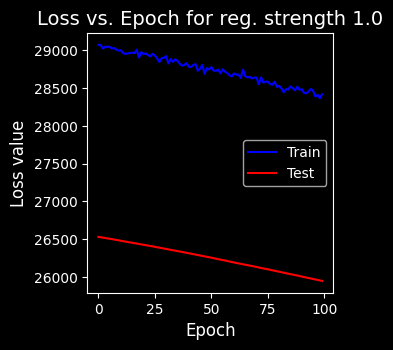

In [143]:
# Plot train and test loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot( history.history['loss'], 'b', label = 'Train')
ax.plot( history.history['val_loss'], 'r', label = 'Test')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.legend()
ax.set_title('Loss vs. Epoch for reg. strength 1.0', fontsize = 14)